In [1]:
###################################################################
#
# Author: Matthew W. Boyce, PhD, boyce.matthew@epa.gov
#
# Version: 1.0 6-08-2020
#
# Description:  This notebook covers the reading, cleaning, and analysis
#               of preliminary GC-MS and LC-MS data generated on by SouthWest Research
#               Institute as pat of the ExpoCast project to analyze the 
#               metabolism of 37 ExpoCast compounds.
#
# Notes: 
#
# Potential issues: None known
#
###################################################################

import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math as math

from statistics import stdev 
from numpy.polynomial.polynomial import polyfit
from scipy import stats
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

pd.set_option('mode.chained_assignment',None) #'raise', 'warn', None

In [2]:
#Read xlsx file with multiple sheets
#Update as needed

file_dir = 'C:\\Users\MBOYCE\Documents\\Expocast_Heptaocyte_LC\\'
GC_file = 'Copy of Hepatocyte_Results_GCGC_Parents.xlsx'

Function #1: readAndClean_GC(fileName)
Read and clean GC data imported from .xlsx file. Returns dictionary that uses k,v pair that corresponds to the sheet name in the xlsx file and a dataframe of the imported data

In [3]:
def readAndClean_GC(fileName):
    xlsx_data = pd.ExcelFile(fileName)
    
    sampleConditions = ['Cell Free', 'Super', 'B-Gluc']    
    sheetFilter = '.*20_.*'
    sampleFilter = '.* R. .*'
    
    sampleNames = [x for x in xlsx_data.sheet_names if re.search(sheetFilter, x)]
    
    GC_DataMap = {}
    
    for sample in sampleNames:
        
        tmpDF = pd.DataFrame(columns = ['Condition','SampleType','Hour', 'Replicate','Area','Ratio','RT'])
        sampleData = xlsx_data.parse(sample)
        
        for index in sampleData.index:
            row = sampleData.loc[index]
            
            if re.match(sampleFilter, row['Sample']) is None:
                continue
            
            sampleCondition = [x for x in sampleConditions if x in row['Sample']]
            if len(sampleCondition) < 1:
                sampleCondition = ["Cell_Pellet"]
                
            sampleType = 'Sample'
           
            hourMatch = re.search(' [0-4]hr ', row['Sample'])
            if hourMatch:
                hourMatch = int(hourMatch.group()[1:2])
                
            else:
                hourMatch = 4
                sampleType = 'Control'
                
            repMatch = re.search(' R[0-3] ', row['Sample'])
            repMatch = repMatch.group()[1:3]
            ratio = [col for col in row.index if 'Ratio' in col]
            
            newRow = {'Condition':sampleCondition[0],'SampleType':sampleType, 'Hour':hourMatch ,'Replicate':repMatch, 'Area':row['Area'], 'Ratio':row[ratio[0]], 'RT':row['R.T. (s)'] }
            tmpDF = tmpDF.append(newRow, ignore_index = True)
        
        GC_DataMap[sample] = {'RawData': tmpDF}
        
    return GC_DataMap
            

Function #3: genRepCountPivot()
Generate pivot tables to summarize the rep counts for each data type (e.g., positive parent, negative parent, positive metaboltie, negative metabolite)

In [4]:
def genRepCountPivot(sheetNames, polarityKey, par_or_metabData):
    columns = ['Sample','Condition','SampleType', 'Hour','Replicate']

    aggDF = pd.DataFrame(columns = columns)
    for sampleName in sheetNames:
        data = LC_DataMap[polarityKey][sampleName][par_or_metabData].dropna()
        data['Sample'] = sampleName
        data = data[columns]
        aggDF = aggDF.append(data)
    repCountPivot = aggDF.pivot_table(index=['Sample','Condition','SampleType','Hour'], aggfunc='size')
    
    return repCountPivot

Funciton #5: genRepMatrix()

In [5]:
def genRepMatrix(compounds, columns, pivotTable):
    
    resultDF = pd.DataFrame(columns = columns, index = compounds)
    for sampleName in compounds:
        for columnName in columns:
            sampleStr = columnName.rsplit("_", 1)
            condition = sampleStr[0]
            sampleType = sampleStr[1]
            hour = 4
            if 'Control' not in sampleType:
                sampleType = 'Sample'
                hour = float(sampleStr[1])
            try:
                reps = int(pivotTable[sampleName][condition][sampleType][hour])
            except:
                reps = int(0)

            finally:
                resultDF.loc[sampleName, columnName] = reps
    return resultDF.to_numpy(dtype = float)

Function #6: plotData()

In [6]:
def plotData(dataDF, compoundList, dataType, variable, addLinReg, addControlCutoff):
    
    if len(compoundList) > 5:
        nCol = 5
        nRow = math.ceil(len(compoundList)/nCol)
    else:
        nCol = compoundList
        nRow = 1

    currCol = 0
    currRow = 0

    # Set up the matplotlib figure
    f, axes = plt.subplots(nRow, nCol, figsize=((nCol * 4), (nRow * 6)), sharex = True)
    sns.despine(left=True)
    for sampleName in compoundList:
        data = dataDF[sampleName][dataType]
        sampleData = data[data['SampleType'] == 'Sample']
        controlData = data[data['SampleType'] == 'Control']

        ax = sns.scatterplot(x = "Hour", y = variable, hue = 'Condition', data = sampleData, 
                             ax = axes[currRow, currCol] if nRow > 1 else axes[currCol])
        ax.set_title(sampleName)   

        dataX = data[data['Condition'] == 'Lysate']['Hour']
        dataY = data[data['Condition'] == 'Lysate'][variable]

                
        currCol = currCol + 1 if currCol < nCol - 1 else 0
        currRow = currRow + 1 if currCol == 0 else currRow

In [7]:
GC_Data = readAndClean_GC(file_dir+'Copy of Hepatocyte_Results_GCGC_Parents.xlsx')

In [8]:
GC_Data.keys()

dict_keys(['020420_methyl_eugenol_rat', '040920_2-nitroaniline', '041320_Lindane', '041320_Benzyl_butyl_phthalate', '041620_BisphenolA', '042020_CP-122721', '042020_opDDT', '042020_2amino5azotoluene', '042720_Beta-HCCH', '042720_Dieldrin', '042920_methyl_eugenol', '051420_BHT', '052120_4Allylanisole'])

In [9]:
## Return counts for each datatype
columns = ['Sample','Condition','SampleType', 'Hour','Replicate']
aggDF = pd.DataFrame(columns = columns)

##count len(set(Replicate))
for sampleName in GC_Data.keys():
    data = GC_Data[sampleName]['RawData'].dropna()
    data['Sample'] = sampleName
    data = data[columns]
    aggDF = aggDF.append(data)

repCount = aggDF.pivot_table(index=['Sample','Condition','SampleType','Hour'], aggfunc='size')
repCount

Sample                     Condition    SampleType  Hour
020420_methyl_eugenol_rat  Cell Free    Control     4       2
                           Cell_Pellet  Sample      0       3
                                                    1       3
                                                    4       3
                           Super        Control     4       3
                                                           ..
051420_BHT                 Cell_Pellet  Sample      4       3
052120_4Allylanisole       Cell Free    Control     4       2
                           Cell_Pellet  Sample      0       3
                                                    1       3
                                                    4       3
Length: 83, dtype: int64

In [10]:
columns = ['Cell Free_Control', 'Cell_Pellet_0', 'Cell_Pellet_1', 'Cell_Pellet_4', 'Super_Control', 'Super_0', 'Super_1', 'Super_4', 'B-Gluc_Control', 'B-Gluc_0', 'B-Gluc_1', 'B-Gluc_4']
compounds = GC_Data.keys()

repCountMatrix = genRepMatrix(GC_Data.keys(), columns, repCount)

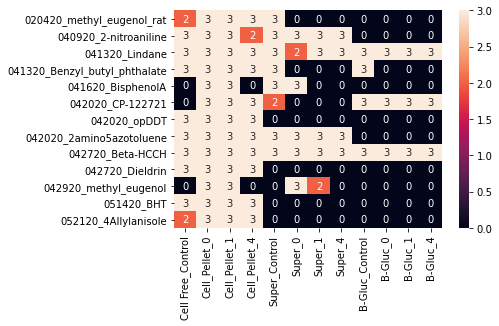

In [11]:
ax = sns.heatmap(repCountMatrix, annot = True, yticklabels=compounds, xticklabels = columns)

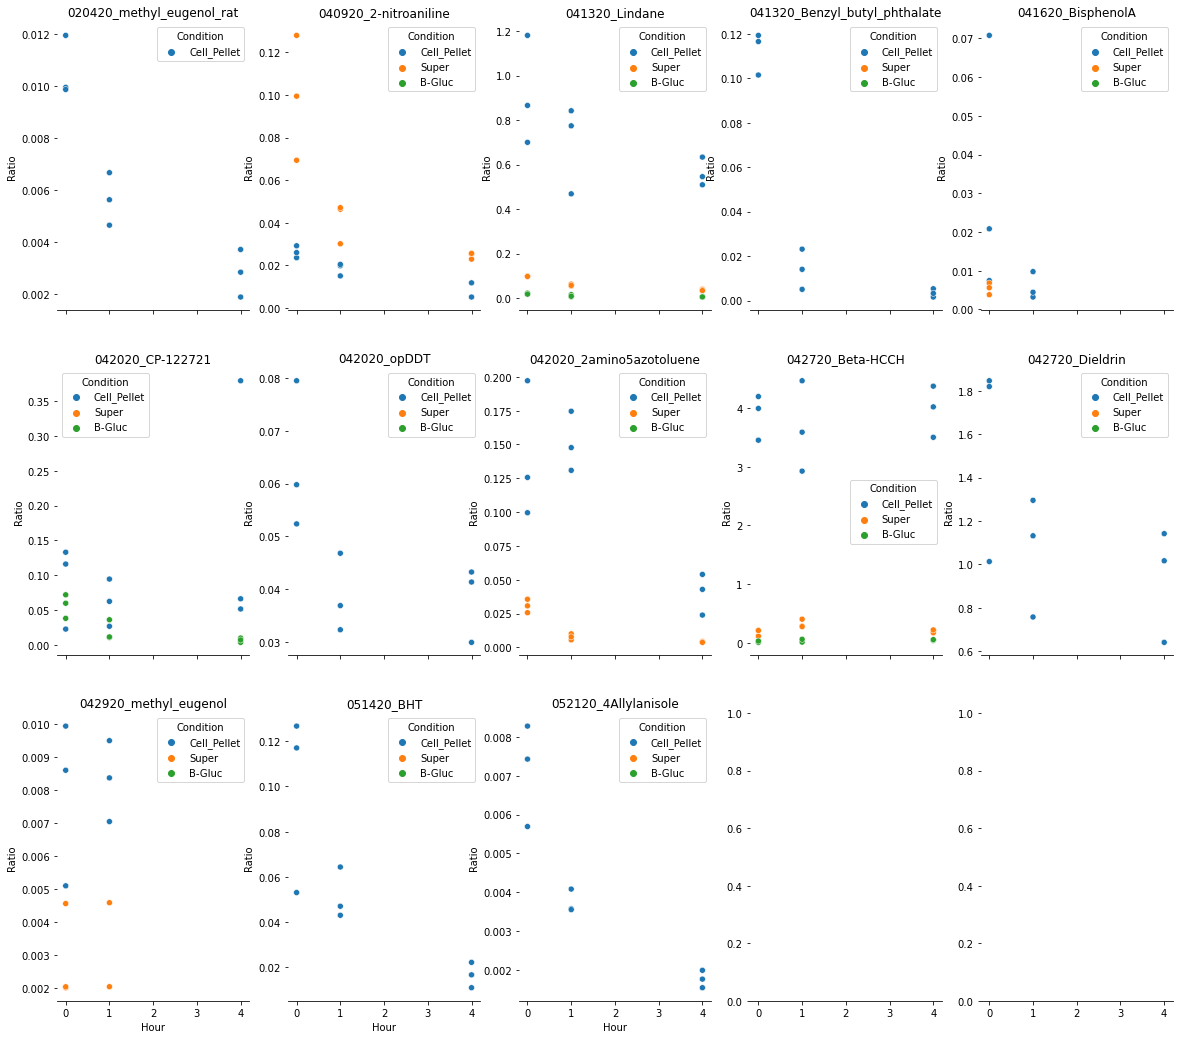

In [12]:
plotData(GC_Data, list(compounds),'RawData', 'Ratio', True, False)

In [13]:
#Summary stats

for key in GC_Data:
    sampleData = GC_Data[key]['RawData']
    controlFilter = ['Super', 'Control']
    sampleFilter = ['Super', 'Sample']
    
    comparisonMetric = 'Ratio' #Can be 'Area' or 'Ratio'
    
    controlData = sampleData.loc[(sampleData['Condition'] == controlFilter[0]) & (sampleData['SampleType'] == controlFilter[1])]
    sampleData_All = sampleData.loc[(sampleData['Condition'] == sampleFilter[0]) & (sampleData['SampleType'] == sampleFilter[1])]
    sampleData_4h = sampleData.loc[(sampleData['Condition'] == sampleFilter[0]) & (sampleData['SampleType'] == sampleFilter[1]) & (sampleData['Hour']==4)]
    
    controlMean = controlData[comparisonMetric].mean()
    controlMean_isNan = math.isnan(controlMean)
    
    sampleMean = sampleData_4h[comparisonMetric].mean()
    sampleMean_isNan = math.isnan(sampleMean)
    
    sigDifference = False
    if (not controlMean_isNan and not sampleMean_isNan):
        ttest = stats.ttest_ind(sampleData_4h[comparisonMetric], controlData[comparisonMetric])
        if ((ttest[0]< 0) and (ttest[1]/2 < 0.05)):
            sigDifference = True
    
    if(
        (not controlMean_isNan and sampleMean_isNan)                                                          # controlMean is a value and sampleMean is not, assume control > sample
        or ((controlMean > sampleMean) & sigDifference)                                                  # controlMean > sample mean, and statistically significant difference
        or (controlMean_isNan and sampleMean_isNan)):                                                         # No measureable control or sample at 4h, unable to remove sample
        print(key + ': Pass' + " ControlMean: " + str(controlMean) + " Sample Mean: " + str(sampleMean))
    else:
        print(key + ': Fail' + " ControlMean: " + str(controlMean) + " Sample Mean: " + str(sampleMean))


020420_methyl_eugenol_rat: Pass ControlMean: 0.0033258000000000003 Sample Mean: nan
040920_2-nitroaniline: Pass ControlMean: 0.08011781528286181 Sample Mean: 0.02462605428504711
041320_Lindane: Pass ControlMean: 0.05552866666666667 Sample Mean: 0.036603
041320_Benzyl_butyl_phthalate: Pass ControlMean: 0.062733 Sample Mean: nan
041620_BisphenolA: Pass ControlMean: 0.04679013333333334 Sample Mean: nan
042020_CP-122721: Pass ControlMean: 0.0020776 Sample Mean: nan
042020_opDDT: Pass ControlMean: nan Sample Mean: nan
042020_2amino5azotoluene: Pass ControlMean: 0.01852353333333333 Sample Mean: 0.004044
042720_Beta-HCCH: Pass ControlMean: 0.42081999999999997 Sample Mean: 0.19636666666666666
042720_Dieldrin: Pass ControlMean: nan Sample Mean: nan
042920_methyl_eugenol: Pass ControlMean: nan Sample Mean: nan
051420_BHT: Pass ControlMean: nan Sample Mean: nan
052120_4Allylanisole: Pass ControlMean: nan Sample Mean: nan


<B>Based on above analysis, all data fit criteria for regression analysis

In [14]:
#Drop na data, filter samples with less than two time points, and add loqAre and loaRatio for first order regressions

for key in GC_Data:
    storedConditions = []
    sampleDF = GC_Data[key]['RawData'].dropna()
    conditions = ['Cell_Pellet', 'Super', 'B-Gluc']
    for condition in conditions:
        conditionFilter = sampleDF['Condition'] == condition
        sampleFilter = sampleDF['SampleType'] == 'Sample'
        timePoints = len(sampleDF['Hour'][conditionFilter & sampleFilter].unique())
        if timePoints >= 2:
            storedConditions += [condition]
            if condition == 'Cell_Pellet':
                storedConditions += ["Cell Free"]
                
    GC_Data[key]['FilteredData'] = None if len(storedConditions) == 0 else sampleDF[sampleDF['Condition'].isin(storedConditions)]
    
    if GC_Data[key]['FilteredData'] is not None:
        GC_Data[key]['FilteredData']['LogArea'] = GC_Data[key]['FilteredData']['Area'].apply(lambda x: np.log(x))
        GC_Data[key]['FilteredData']['LogRatio'] = GC_Data[key]['FilteredData']['Ratio'].apply(lambda x: np.log(x))

In [15]:
GC_Data[list(GC_Data.keys())[0]]['FilteredData']

,Condition,SampleType,Hour,Replicate,Area,Ratio,RT,LogArea,LogRatio
0,Cell Free,Control,4,R2,58061.0,0.004054,"1000 , 1.879",10.969249,-5.508002
1,Cell Free,Control,4,R3,67597.0,0.005095,"1000 , 1.910",11.121319,-5.279456
2,Cell_Pellet,Sample,0,R1,41291.0,0.009954,"1005 , 1.870",10.628400,-4.609731
3,Cell_Pellet,Sample,0,R2,44483.0,0.009873,"1005 , 1.885",10.702862,-4.617941
4,Cell_Pellet,Sample,0,R3,48270.0,0.011951,"1005 , 1.899",10.784566,-4.426940
5,Cell_Pellet,Sample,1,R1,19958.0,0.004658,"1005 , 1.890",9.901385,-5.369234
6,Cell_Pellet,Sample,1,R2,19135.0,0.006675,"1010 , 1.870",9.859274,-5.009356
7,Cell_Pellet,Sample,1,R3,17069.0,0.005635,"1010 , 1.869",9.745019,-5.178811
8,Cell_Pellet,Sample,4,R1,6153.9,0.001897,"1005 , 1.860",8.724841,-6.267692
9,Cell_Pellet,Sample,4,R2,9526.9,0.002851,"1005 , 1.860",9.161875,-5.859910


In [16]:
nonEmptyFiltered = 0
nonEmptyKey = []
for k in GC_Data:
    if GC_Data[k]['FilteredData'] is not None:
        nonEmptyFiltered += 1
        nonEmptyKey += [k] 
        
nonEmptyFiltered

13

In [17]:
allData = None
allData = pd.DataFrame(columns = ['Sample', 'Condition', 'SampleType', 'Hour','Replicate', 'Area', 'Ratio', 'RT', 'LogArea', 'LogRatio'])
for key in GC_Data:
    tmpDF = GC_Data[key]['FilteredData']
    tmpDF['Sample'] = key
    allData = allData.append(tmpDF)
allData

,Sample,Condition,SampleType,Hour,Replicate,Area,Ratio,RT,LogArea,LogRatio
0,020420_methyl_eugenol_rat,Cell Free,Control,4,R2,58061,0.004054,"1000 , 1.879",10.969249,-5.508002
1,020420_methyl_eugenol_rat,Cell Free,Control,4,R3,67597,0.005095,"1000 , 1.910",11.121319,-5.279456
2,020420_methyl_eugenol_rat,Cell_Pellet,Sample,0,R1,41291,0.009954,"1005 , 1.870",10.628400,-4.609731
3,020420_methyl_eugenol_rat,Cell_Pellet,Sample,0,R2,44483,0.009873,"1005 , 1.885",10.702862,-4.617941
4,020420_methyl_eugenol_rat,Cell_Pellet,Sample,0,R3,48270,0.011951,"1005 , 1.899",10.784566,-4.426940
...,...,...,...,...,...,...,...,...,...,...
6,052120_4Allylanisole,Cell_Pellet,Sample,1,R2,29848,0.004079,"588 , 1.140",10.303873,-5.502017
7,052120_4Allylanisole,Cell_Pellet,Sample,1,R3,25745,0.003550,"588 , 1.129",10.155996,-5.640846
8,052120_4Allylanisole,Cell_Pellet,Sample,4,R1,15957,0.001986,"588 , 1.129",9.677653,-6.221778
9,052120_4Allylanisole,Cell_Pellet,Sample,4,R2,13879,0.001536,"588 , 1.126",9.538132,-6.478314


In [18]:
allData['Hour']= allData['Hour'].astype('float64')

In [19]:
allData[allData['SampleType']=='Sample']

,Sample,Condition,SampleType,Hour,Replicate,Area,Ratio,RT,LogArea,LogRatio
2,020420_methyl_eugenol_rat,Cell_Pellet,Sample,0.0,R1,41291,0.009954,"1005 , 1.870",10.628400,-4.609731
3,020420_methyl_eugenol_rat,Cell_Pellet,Sample,0.0,R2,44483,0.009873,"1005 , 1.885",10.702862,-4.617941
4,020420_methyl_eugenol_rat,Cell_Pellet,Sample,0.0,R3,48270,0.011951,"1005 , 1.899",10.784566,-4.426940
5,020420_methyl_eugenol_rat,Cell_Pellet,Sample,1.0,R1,19958,0.004658,"1005 , 1.890",9.901385,-5.369234
6,020420_methyl_eugenol_rat,Cell_Pellet,Sample,1.0,R2,19135,0.006675,"1010 , 1.870",9.859274,-5.009356
...,...,...,...,...,...,...,...,...,...,...
6,052120_4Allylanisole,Cell_Pellet,Sample,1.0,R2,29848,0.004079,"588 , 1.140",10.303873,-5.502017
7,052120_4Allylanisole,Cell_Pellet,Sample,1.0,R3,25745,0.003550,"588 , 1.129",10.155996,-5.640846
8,052120_4Allylanisole,Cell_Pellet,Sample,4.0,R1,15957,0.001986,"588 , 1.129",9.677653,-6.221778
9,052120_4Allylanisole,Cell_Pellet,Sample,4.0,R2,13879,0.001536,"588 , 1.126",9.538132,-6.478314


In [20]:
allData['Condition'] = allData['Condition'].apply(lambda x: x.replace(" ", "_").replace("-","_"))

In [21]:
allData.to_csv("allData.csv")

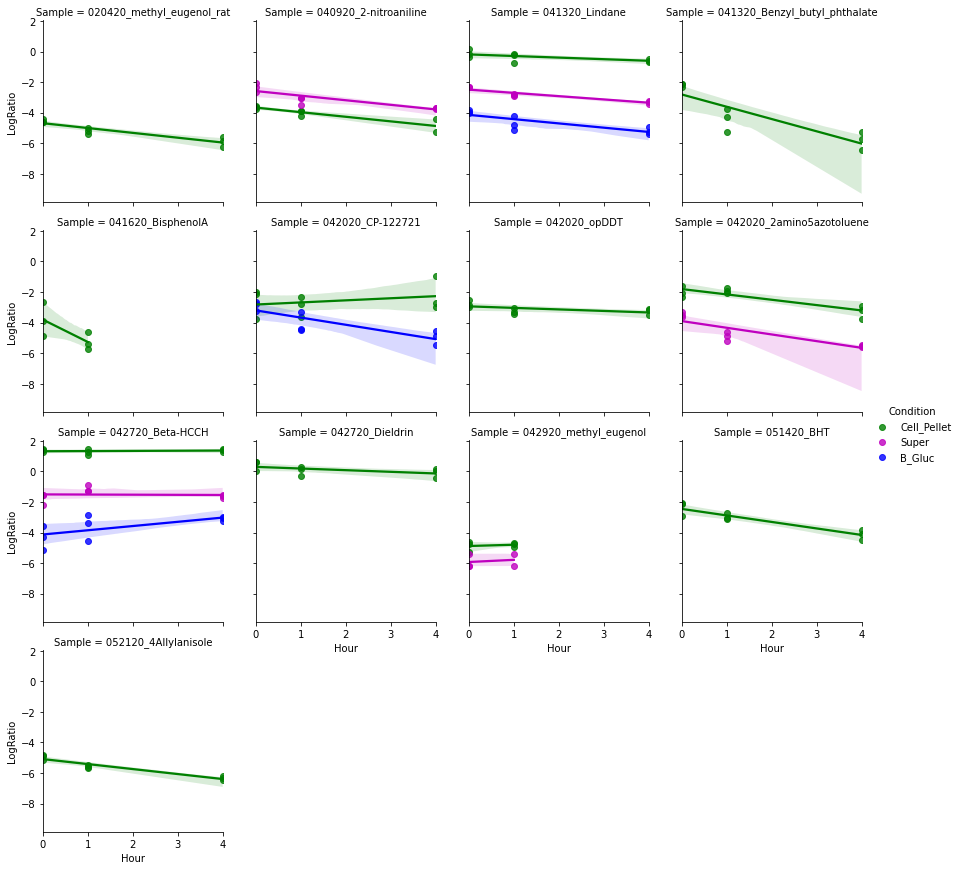

In [22]:
g = sns.lmplot(x="Hour", y="LogRatio", col="Sample", hue="Condition",
               data=allData[allData['SampleType'] == 'Sample'],col_wrap=4, height=3, 
               palette=dict(Cell_Pellet="g", Super="m", B_Gluc="b"))

In [24]:
regDF = pd.DataFrame(columns = ['Sample','SampleType','Regress_Slope', 'Regress_Intercept', 'Regress_RValue','Regress_PValue','Regress_StdErr'])
analysisMetric = "LogRatio"

samplesForRegression = list(GC_Data.keys())

for sample in samplesForRegression:
    subSample = allData[(allData['Sample'] == sample) & (allData['SampleType']=='Sample')]
    sampleConditions = subSample['Condition'].unique()
    
    for condition in sampleConditions:
        dataX = np.array(subSample[subSample['Condition']==condition]['Hour']).astype(float)
        dataY = np.array(subSample[subSample['Condition']==condition][analysisMetric]).astype(float)
        
        try:
            regression = stats.linregress(dataX, dataY)
            
        except:
            continue
        
        if(not math.isnan(regression[0])):
            tmpDF = pd.DataFrame(columns = ['Sample','SampleType','Regress_Slope', 'Regress_Intercept', 'Regress_RValue','Regress_PValue','Regress_StdErr'],
                            data = [[sample, condition] + list(regression)])
            regDF = regDF.append(tmpDF, ignore_index = True)
        
regDF


,Sample,SampleType,Regress_Slope,Regress_Intercept,Regress_RValue,Regress_PValue,Regress_StdErr
0,020420_methyl_eugenol_rat,Cell_Pellet,-0.316118,-4.687885,-0.918714,0.000465,0.051361
1,040920_2-nitroaniline,Cell_Pellet,-0.299702,-3.668249,-0.897614,0.002481,0.060083
2,040920_2-nitroaniline,Super,-0.299894,-2.586387,-0.858512,0.003046,0.067704
3,041320_Lindane,Cell_Pellet,-0.104023,-0.189024,-0.635337,0.065959,0.047789
4,041320_Lindane,Super,-0.213536,-2.491936,-0.937409,0.000585,0.032384
5,041320_Lindane,B_Gluc,-0.278610,-4.143694,-0.821255,0.006643,0.073160
6,041320_Benzyl_butyl_phthalate,Cell_Pellet,-0.802533,-2.810455,-0.870924,0.002237,0.171153
7,041620_BisphenolA,Cell_Pellet,-1.461382,-3.807507,-0.706790,0.116354,0.731346
8,042020_CP-122721,Cell_Pellet,0.136501,-2.816398,0.289311,0.450198,0.170702
9,042020_CP-122721,B_Gluc,-0.469339,-3.201914,-0.843274,0.004290,0.113067


In [25]:
regDF_filtered = regDF[regDF['Regress_PValue'] <= 0.05 ]
regDF_filtered

,Sample,SampleType,Regress_Slope,Regress_Intercept,Regress_RValue,Regress_PValue,Regress_StdErr
0,020420_methyl_eugenol_rat,Cell_Pellet,-0.316118,-4.687885,-0.918714,0.000465,0.051361
1,040920_2-nitroaniline,Cell_Pellet,-0.299702,-3.668249,-0.897614,0.002481,0.060083
2,040920_2-nitroaniline,Super,-0.299894,-2.586387,-0.858512,0.003046,0.067704
4,041320_Lindane,Super,-0.213536,-2.491936,-0.937409,0.000585,0.032384
5,041320_Lindane,B_Gluc,-0.278610,-4.143694,-0.821255,0.006643,0.073160
6,041320_Benzyl_butyl_phthalate,Cell_Pellet,-0.802533,-2.810455,-0.870924,0.002237,0.171153
9,042020_CP-122721,B_Gluc,-0.469339,-3.201914,-0.843274,0.004290,0.113067
11,042020_2amino5azotoluene,Cell_Pellet,-0.348796,-1.807509,-0.875587,0.001976,0.072732
12,042020_2amino5azotoluene,Super,-0.436751,-3.901453,-0.864356,0.002644,0.096041
19,051420_BHT,Cell_Pellet,-0.425230,-2.456724,-0.920513,0.000431,0.068218


In [26]:
regDF_filtered['Sample']

0         020420_methyl_eugenol_rat
1             040920_2-nitroaniline
2             040920_2-nitroaniline
4                    041320_Lindane
5                    041320_Lindane
6     041320_Benzyl_butyl_phthalate
9                  042020_CP-122721
11         042020_2amino5azotoluene
12         042020_2amino5azotoluene
19                       051420_BHT
20             052120_4Allylanisole
Name: Sample, dtype: object

In [27]:
sampleFilter = list(zip(regDF_filtered['Sample'],regDF_filtered['SampleType']))
sampleFilter

[('020420_methyl_eugenol_rat', 'Cell_Pellet'),
 ('040920_2-nitroaniline', 'Cell_Pellet'),
 ('040920_2-nitroaniline', 'Super'),
 ('041320_Lindane', 'Super'),
 ('041320_Lindane', 'B_Gluc'),
 ('041320_Benzyl_butyl_phthalate', 'Cell_Pellet'),
 ('042020_CP-122721', 'B_Gluc'),
 ('042020_2amino5azotoluene', 'Cell_Pellet'),
 ('042020_2amino5azotoluene', 'Super'),
 ('051420_BHT', 'Cell_Pellet'),
 ('052120_4Allylanisole', 'Cell_Pellet')]

In [28]:
sigData = pd.DataFrame(columns = allData.columns)
for (sample,condition) in sampleFilter:
    sigData = sigData.append(allData[(allData['Sample']==sample)&(allData['Condition']==condition)])

In [31]:
sigData.to_csv("significantData.csv")

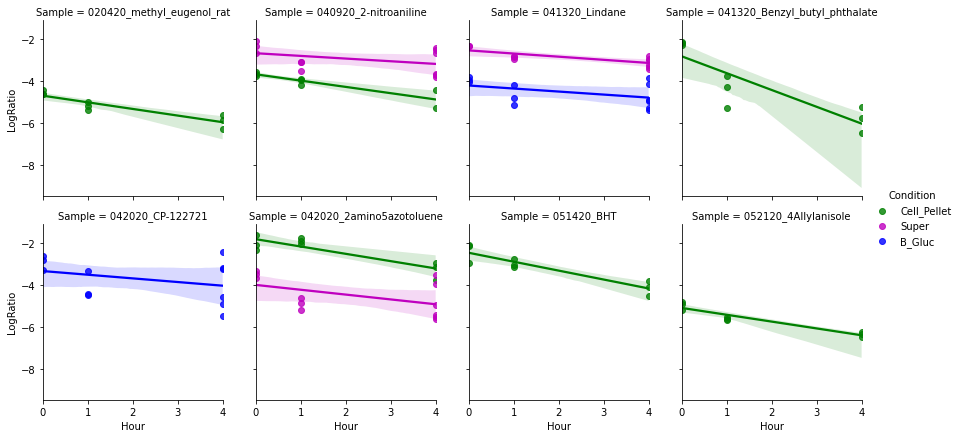

In [29]:
sigPlots = sns.lmplot(x="Hour", y="LogRatio", col="Sample", hue="Condition",
               data=sigData,col_wrap=4, height=3,
               palette=dict(Cell_Pellet="g", Super="m", B_Gluc="b"))